- ### SVM, Logistic regression, AUC-ROC, AUC_PR 
- ### methods of transformation of variables 
- ### methods of selection of features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

C:\Users\krup1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# SVM, LR, calibration of probabilities

Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

- #### Обучим метод орорных векторов
- #### Подберем параметр регуляризации с точки зрения AUC-PR

In [5]:
#подсчет AUC-PR
def auc_pr(y_test, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [6]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X = scl.fit_transform(X)

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [7]:
#подбор гиперпараметра С (подбирается с использованием валидационной выборки)
def c_best_selection (C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0
    
    for C_i in C_set:
        clf.C = C_i

        clf.fit(X_t, y_t)
        a_x = clf.predict(X_val)

        #вычисляем precision и recall
        precision, recall, thresholds = precision_recall_curve(y_val, a_x)
        #считаем площадь под кривыми precision и recall
        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i
    print("Подобранный параметр С =", C)
    return C

In [8]:
best_c_linearSVC = c_best_selection(list(np.logspace(-20, 30, 100)), LinearSVC(), X_train1, y_train1, X_val, y_val)

Подобранный параметр С = 68926121043497.375


На тестовой части посторим ROC и PR кривые, посчитем AUC-ROC, AUC-PR.


Сравним AUC-ROC и AUC-PR с этими же метриками для случайного классификатора.

### Считаем

In [9]:
#зафиксируем подобранный параметр C, обучим модель, сделаем прогноз
clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

In [10]:
#посчитаем метрики 
precision, recall, thresholds_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, thresholds_roc = roc_curve(y_test, a_x)

In [11]:
#считаем AUC-ROC, AUC-PR с точностью до 5 знаков
print ("AUC-ROC : %0.5f" % auc(fpr, tpr))
print ("AUC-PR : %0.5f" % auc(recall, precision))

AUC-ROC : 0.74897
AUC-PR : 0.81456


### Строим

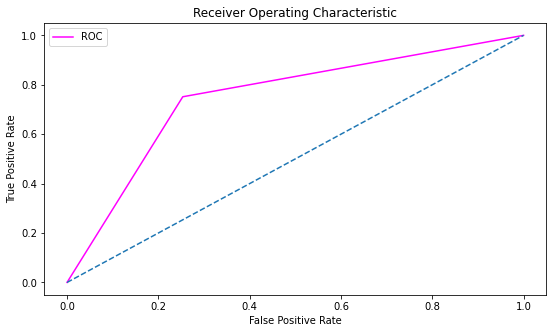

In [12]:
plt.figure(figsize=(9, 5))

plt.plot(fpr, tpr, color='magenta', label='ROC')
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

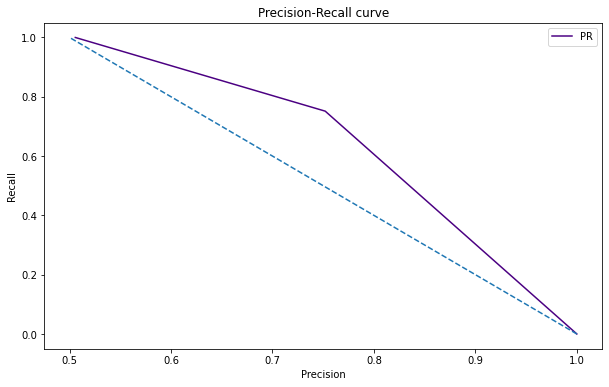

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(precision, recall, color='indigo', label='PR')
plt.plot([1, 0.5], [0, 1], linestyle='--')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

### Сравниваем

**Заметим, что прогнозы нашей модели лучше, чем прогнозы случайного классификатора. Это легко понять, потому что ROC и PR кривые лежат выше диагонали.**

### Посмотрим на качетво при использовании логистической регрессии с тем же набором действий

In [14]:
best_c_LR = c_best_selection(list(np.logspace(-20, 30, 100)), LogisticRegression(), X_train1, y_train1, X_val, y_val)

Подобранный параметр С = 0.015199110829529393


In [15]:
#зафиксируем подобранный параметр C, обучим модель, сделаем прогноз
clf = LogisticRegression()
clf.C = best_c_LR
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

#посчитаем метрики 
precision, recall, thresholds_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, thresholds_roc = roc_curve(y_test, a_x)

#считаем AUC-ROC, AUC-PR с точностью до 5 знаков
print ("AUC-ROC : %0.5f" % auc(fpr, tpr))
print ("AUC-PR : %0.5f" % auc(recall, precision))

AUC-ROC : 0.77101
AUC-PR : 0.83092


### Строим

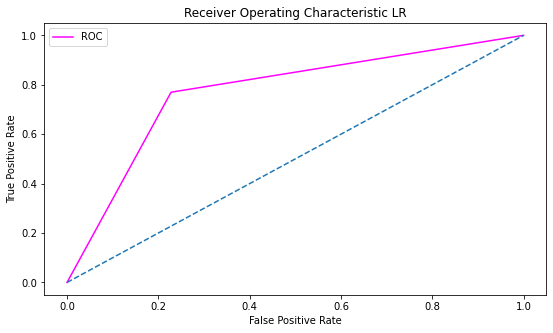

In [16]:
plt.figure(figsize=(9, 5))

plt.plot(fpr, tpr, color='magenta', label='ROC')
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic LR')
plt.legend()
plt.show()

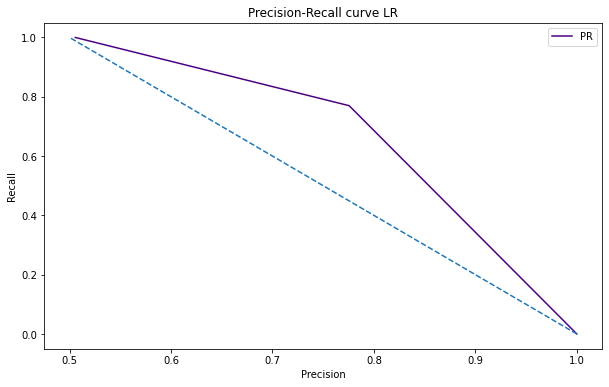

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(precision, recall, color='indigo', label='PR')
plt.plot([1, 0.5], [0, 1], linestyle='--')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve LR')
plt.legend()
plt.show()

### Сравнение результатов LR и SVM

### Заметим, что результаты получились примерно одинаковыми.

**На мой взгляд, они незначительно различаются из-за того, что LR и SVM представляют разные принципы классификации, т.е. в основе LR лежит теория вероятностей (вероятность того, что выборка равна 1, может быть представлена сигмоидальной функцией, а затем значение параметра оценивается методом оценки максимального правдоподобия), а в SVM максимизации геометрического интервала (плоскость классификации с наибольшим геометрическим интервалом считается оптимальной плоскостью классификации).**

**Еще видим, что LR сработало чуть похуже, это понятно, так как от нее мы требуем точной оценки вероятности, SVM сработал получше, так как здесь главная задача хорошо разделить объекты (без ошибок), не говоря о степени уверенности в классе.**


### Калибровка вероятностей.

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

In [23]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)])) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

### Сгенерируем данные

In [24]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X = scl.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Обучаем тестируем логистическую регрессию, строим колибровочную кривую

Text(0.5, 1.0, 'Сalibration curve LR')

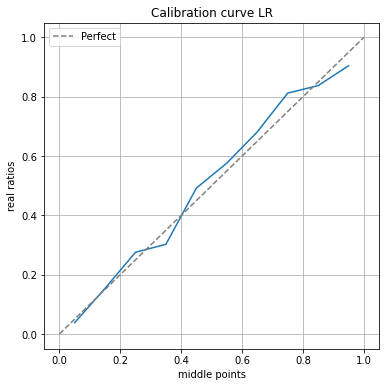

In [25]:
clf = LogisticRegression()
clf.probability = True
clf.fit(X_train, y_train)
lr_pred = clf.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, lr_pred)
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='grey')
plt.legend()

plt.xlabel('middle points')
plt.ylabel('real ratios')
plt.title('Сalibration curve LR')

### Обучаем тестируем метод опорных векторов, строим колибровочную кривую

Text(0.5, 1.0, 'Сalibration curve SVC')

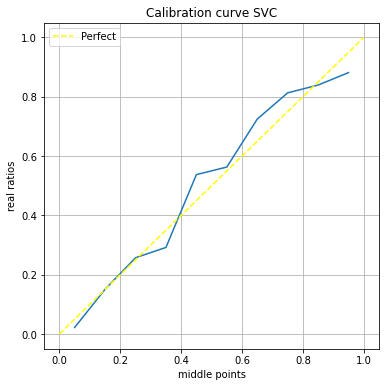

In [26]:
clf = SVC(kernel='linear')
clf.probability = True
clf.fit(X_train, y_train)
svc_pred = clf.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, svc_pred)
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='yellow')
plt.legend()

plt.xlabel('middle points')
plt.ylabel('real ratios')
plt.title('Сalibration curve SVC')

**Смотря на калибровочные кривые, кажется, что LR справилась чуть лучше. Но вообще сильных отличий не видно.**

### Посмотрим на распределение ответов классификаторов 

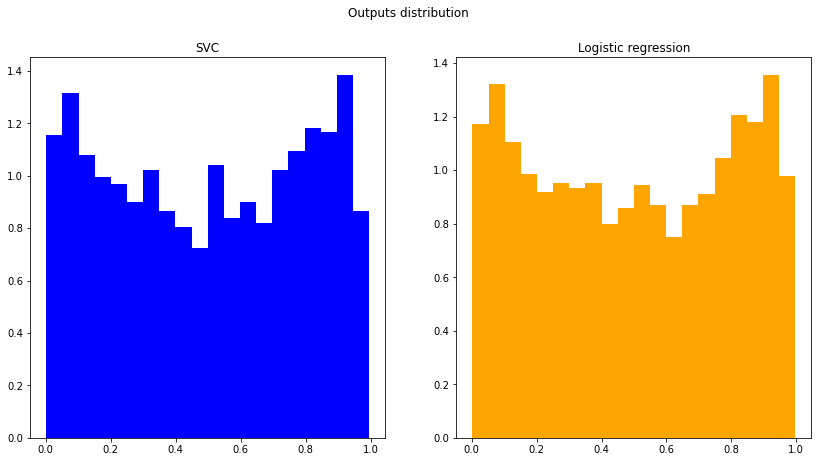

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Про отличия трудно что-то сказать, так как, смотря на графики, их почти не видно. Незначительные есть, могу объяснить это тем, что LR и SVM представляют разные принципы классификации, как было описано выше.**

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

Воспользуемся CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении, построим с его помощью предсказания для тестовой выборки. Проанализируем калибровочную кривую.

### Обучаем, тестируем и строим

Text(0.5, 1.0, 'Сalibration curve SVC (CalibratedClassifierCV)')

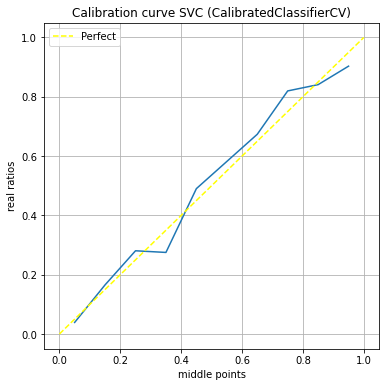

In [28]:
clf = CalibratedClassifierCV()
clf.probability = True
clf.fit(X_train, y_train)
ccl_pred = clf.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, ccl_pred)
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='yellow')
plt.legend()

plt.xlabel('middle points')
plt.ylabel('real ratios')
plt.title('Сalibration curve SVC (CalibratedClassifierCV)')

**Кажется, что калибровочная кривая стала лучше, т.е. отклоняться от идеала она стала меньше.**

# Работаем с переменными

Посмотрим на два основных способа обработки категориальных значений:
- One-hot-кодирование
- CTR, mean-target кодирование — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

In [30]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional-full.csv', sep=';')

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [31]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Если обратить внимание на последний столбец, то можно увидеть, что он называется 'y' и содержит значения: 'no', 'yes'. Закодируем отдельно целевую переменную 1- 'yes', 0 - 'no'.**

In [32]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [33]:
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1

In [34]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1


**В описании даных можно найти следующее: 'duration' сильно влияет на цель вывода. Тем не менее, продолжительность вызова до выполнения вызова неизвестна. Кроме того, после окончания звонка, очевидно, известно y. Таким образом, эти входные данные следует включать только для целей эталонного тестирования и от них следует отказаться, если предполагается получить реалистичную прогностическую модель.**

In [35]:
df.drop(columns='duration', inplace=True)

🛑 **Разделим выборку перед обучением, после кодирования** 🛑

РАССУЖДЕНИЯ

**Наша задача состоит в том, чтобы привлечь как можно больше клиентов, то есть мы должны больше думать о том, как бы не пропустить положительный объект. Выбираем AUC-PR, так как PR AUC смотрит на положительную прогностическую ценность и истинно положительный показатель. А вот AUC-ROC, например, смотрит на истинно положительный уровень TPR и ложноположительный уровень FPR.**

### Разделим признаки на категориальные и вещественные

In [36]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

### Подготовка к обучению модели

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [38]:
#для кодирования категориальных признаков используем OrdinalEncoder
enc = OrdinalEncoder()

In [39]:
#вещественные признаки также отмасштабируем
date = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

### Переходим к обучению 

In [40]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [41]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели при OrdinalEncoder:', time.time() - start_time)
print("AUC-PR при OrdinalEncoder = %.5f" % auc_pr(y_test, y_pred))
print('Кол-во столбцов ', date.fit_transform(X_train).shape[1])

Время на обучение модели при OrdinalEncoder: 0.4340336322784424
AUC-PR при OrdinalEncoder = 0.95330
Кол-во столбцов  19


- Закодируем все категориальные признаки с помощью one-hot-кодирования. 
- Обучим логистическую регрессию и посмотрим на измениния в качестве модели. 
- Измерим время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [42]:
#для кодирования категориальных признаков используем OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")

#вещественные признаки также отмасштабируем
date = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

In [43]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при OneHotEncoder = %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', date.fit_transform(X_train).shape[1])

Время на обучение модели: 0.7325587272644043
AUC-PR при OneHotEncoder = 0.95339
Кол-во столбцов  62


### Сравнение OrdinalEncoder и OneHotEncoder

- OneHotEncoder работал почти в два раза дольше по времени 
- По качеству почти одинаково (ohe на 0, 00009 лучше)

### mean-target encoding 


Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

- Закодируем категориальные переменные с помощью счётчиков 
- Обучим логистическую регрессию и посмотрим на качество модели на тестовом множестве
- Сравним время обучения с предыдущими экспериментами

In [44]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

### Кодирование категориальных, обучение модели и тестирование

In [45]:
start_time = time.time()

#переходим к кодированию. Будем идти по каждому из столбцов внутри каждой категории.
for col in cat:
    for categ in list(pd.unique(X_train[col])):
        #используем формулу
        g_train = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0] / X_train[X_train[col] == categ].shape[0]
        X_train.loc[X_train[col] == categ, col] = g_train
        
        
        g_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0] / X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_test 

#обучение, тестировние        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding = %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 1.2769110202789307
AUC-PR при mean-target encoding = 0.95312
Кол-во столбцов  19


- Дольше по времени 
- Чуть хуже по качеству по сравнению с OneHotEncoder и OrdinalEncoder

### Реализуем корректное вычисление счётчиков с добавлением шума к значениям 

In [46]:
start_time = time.time()
for col in cat:
    #добавим шума к категориальным признакам
    X_train[col] += np.random.rand(X_train.shape[0]) * np.sign(np.random.rand(X_train.shape[0]) - 0.5) / 10
    X_test[col] += np.random.rand(X_test.shape[0]) * np.sign(np.random.rand(X_test.shape[0]) - 0.5) / 10

clf = LogisticRegression()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding и шуме= %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.5270411968231201
AUC-PR при mean-target encoding и шуме= 0.95217
Кол-во столбцов  19


- Качество упало, но не критично
- Про время тут говорить странно, так как некоторые данные пришли к нам из предыдущего задания. 

Некоторая категория может встречается в выборке всего несколько раз. По этой причине производится сглаживание счётчиков:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания. Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Добавим сглаживание, описанное выше и повторим эксперименты.

In [48]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [49]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

In [50]:
start_time = time.time()

#параметр определяющий степень сглаживания
C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.3323535919189453
AUC-PR при global mean = 0.95536


- **При использовании сглаживания средним по всей выборке качетсво модели выросло, кажется, что в данных действительно встречались редкие категории**

В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений, поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуем закодировать возраст с помощью счетчиков. 

In [51]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [52]:
print('Кол-во уникальных возрастов', len(list(pd.unique(df['age']))))

Кол-во уникальных возрастов 78


In [53]:
#теперь возраст категориальная переменная
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [54]:
start_time = time.time()

#параметр определяющий степень сглаживания
C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.9548194408416748
AUC-PR при global mean = 0.96042


- **Стало значительно лучше)**
- Чуть чуть затратнее по времени

**Плюсы счетчиков:**
- Улучшают качетство модели)
- Экономят память (кол-во признаков не изменяется)

**Минусы счетчиков:**
- Хорошо работают, только когда в признаках есть редкие категории
- Нужно писать вручную (да, возможно в какой-то библиотеке они есть)
- Затратные по времени (у меня получилось что ohe работал быстрее)

# Работа с признаками. Отбор.

In [59]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Вспомним как были разделены признаки (на вещественные и категориальные)

In [60]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

### Закодируем категориальрные признаки с помощью one-hot кодирования

**Будем использовать метод get_dummies**

In [61]:
#для красивого вывода названий столбцов
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [62]:
X_train.head(5)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
38757,37,1,999,0,-3.4,92.649,-30.1,0.715,5017.5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
40369,30,1,999,1,-1.7,94.027,-38.3,0.900,4991.6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27545,57,2,999,0,-0.1,93.200,-42.0,4.021,5195.8,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
34606,46,1,999,1,-1.8,92.893,-46.2,1.266,5099.1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7869,55,2,999,0,1.4,94.465,-41.8,4.865,5228.1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [63]:
print('Мы получили', X_train.shape[1], 'признака')

Мы получили 52 признака


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. 
- Обучим модель и посчитаем качество на тестовой выборке. 
- Запомним полученное значение.

In [64]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

#запомнили значение
auc_pr_lr_ohe = auc_pr(y_test,a_x)

print("AUC-PR = %.5f" %  auc_pr_lr_ohe)

AUC-PR = 0.95224


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставим 40 признаков с наибольшим модулем соответствующего параметра линейной модели. 

In [65]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)

Время на обучение модели: 0.5303897857666016
AUC-PR (40 признаков) = 0.95202


- **Качество упало, но незначительно**

Учтем разный масштаб признаков

### Отмасшабируем признаки с помощью StandartScaler и OHE

**Снова разделим данные**

In [66]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Кодирование

In [67]:
#вещественные признаки отмасштабируем с помощью StandardScaler, категориальные пока не трогаем
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])

X_train = pd.DataFrame(date.fit_transform(X_train))
X_test = pd.DataFrame(date.transform(X_test))

In [68]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, columns=X_train.iloc[:, 0:10].columns, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=X_test.iloc[:, 0:10].columns, drop_first=True)

### Теперь мы имеем набор данных, которые  отмасштабированы и закодированы

In [69]:
X_train.head(5)

,10,11,12,13,14,15,16,17,18,0_blue-collar,0_entrepreneur,0_housemaid,0_management,0_retired,0_self-employed,0_services,0_student,0_technician,0_unemployed,0_unknown,1_married,1_single,1_unknown,2_basic.6y,2_basic.9y,2_high.school,2_illiterate,2_professional.course,2_university.degree,2_unknown,3_unknown,3_yes,4_unknown,4_yes,5_unknown,5_yes,6_telephone,7_aug,7_dec,7_jul,7_jun,7_mar,7_may,7_nov,7_oct,7_sep,8_mon,8_thu,8_tue,8_wed,9_nonexistent,9_success
0,-0.289536,-0.567466,0.196418,-0.351015,-2.21359,2.24946,-1.59958,-1.66975,-2.06184,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,-0.958139,-0.567466,0.196418,1.66534,-1.13182,0.477886,0.781528,-1.56325,-2.41943,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.62076,-0.203565,0.196418,-0.351015,-0.113695,-0.321482,-0.647481,0.233315,0.399899,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0.570097,-0.567466,0.196418,1.66534,-1.19546,-1.22887,-1.17796,-1.35257,-0.93521,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.53837,0.719154,0.845855,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


**Теперь выберем 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модель, оценим её качество.**

In [70]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [71]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.5031001567840576
AUC-PR (40 признаков) = 0.95215
indices = Int64Index([16, 26, 13,  5, 47, 48, 45, 20, 29, 18,  0, 28, 11, 17, 24, 33, 25,
            10, 12,  3, 39, 31, 14, 35, 32, 34, 27, 15,  1, 44, 19,  2, 46,  9,
            30, 42, 43, 40, 36,  4],
           dtype='int64')


**Качество стало немного лучше, НО по сравнению с первоначальной моделью (где используются все признаки) оно ниже (незначительно)**

In [72]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [73]:
#закодировали категории
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [74]:
#отмасштабируем все!
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [75]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,-0.289536,-0.567466,0.196418,-0.351015,-2.213588,-1.599578,2.249459,-1.669748,-2.061837,-0.532812,-0.191023,-0.163315,-0.275507,-0.212798,-0.190437,-0.325694,-0.144789,-0.444409,-0.159698,-0.090458,-1.236273,1.597749,-0.044897,-0.238199,-0.411209,1.813574,-0.020406,-0.383823,-0.649451,-0.21128,-0.510860,-0.008329,-0.153774,-1.049542,-0.153774,2.353219,-0.754457,-0.423014,-0.067301,-0.460045,-0.384120,-0.116643,-0.706923,3.015187,-0.133387,-0.114951,-0.509996,-0.513342,-0.497766,2.028000,0.398208,-0.185992
1,-0.958139,-0.567466,0.196418,1.665344,-1.131825,0.781528,0.477886,-1.563255,-2.419431,-0.532812,-0.191023,-0.163315,-0.275507,-0.212798,-0.190437,-0.325694,-0.144789,-0.444409,-0.159698,-0.090458,-1.236273,1.597749,-0.044897,-0.238199,-0.411209,-0.551397,-0.020406,-0.383823,1.539761,-0.21128,-0.510860,-0.008329,-0.153774,-1.049542,-0.153774,-0.424950,1.325457,2.363988,-0.067301,-0.460045,-0.384120,-0.116643,-0.706923,-0.331654,-0.133387,-0.114951,-0.509996,-0.513342,-0.497766,2.028000,-2.511252,-0.185992
2,1.620760,-0.203565,0.196418,-0.351015,-0.113695,-0.647481,-0.321482,0.233315,0.399899,1.876835,-0.191023,-0.163315,-0.275507,-0.212798,-0.190437,-0.325694,-0.144789,-0.444409,-0.159698,-0.090458,0.808883,-0.625880,-0.044897,-0.238199,2.431853,-0.551397,-0.020406,-0.383823,-0.649451,-0.21128,1.957483,-0.008329,-0.153774,0.952797,-0.153774,2.353219,-0.754457,-0.423014,-0.067301,-0.460045,-0.384120,-0.116643,-0.706923,3.015187,-0.133387,-0.114951,-0.509996,-0.513342,-0.497766,-0.493097,0.398208,-0.185992
3,0.570097,-0.567466,0.196418,1.665344,-1.195458,-1.177960,-1.228873,-1.352571,-0.935210,-0.532812,-0.191023,-0.163315,-0.275507,-0.212798,-0.190437,3.070362,-0.144789,-0.444409,-0.159698,-0.090458,0.808883,-0.625880,-0.044897,-0.238199,-0.411209,1.813574,-0.020406,-0.383823,-0.649451,-0.21128,-0.510860,-0.008329,-0.153774,0.952797,-0.153774,-0.424950,-0.754457,-0.423014,-0.067301,-0.460045,-0.384120,-0.116643,1.414582,-0.331654,-0.133387,-0.114951,-0.509996,1.948019,-0.497766,-0.493097,-2.511252,-0.185992
4,1.429730,-0.203565,0.196418,-0.351015,0.840802,1.538367,-0.278273,0.719154,0.845855,-0.532812,5.234971,-0.163315,-0.275507,-0.212798,-0.190437,-0.325694,-0.144789,-0.444409,-0.159698,-0.090458,-1.236273,-0.625880,-0.044897,-0.238199,-0.411209,-0.551397,-0.020406,-0.383823,1.539761,-0.21128,-0.510860,-0.008329,-0.153774,0.952797,-0.153774,2.353219,1.325457,-0.423014,-0.067301,-0.460045,2.603353,-0.116643,-0.706923,-0.331654,-0.133387,-0.114951,1.960799,-0.513342,-0.497766,-0.493097,0.398208,-0.185992


In [76]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [77]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf = LogisticRegression()
clf.fit(x_train, y_train)
a_x = clf.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.16501235961914062
AUC-PR (40 признаков) = 0.95231
indices = Int64Index([47, 48,  0, 13, 38, 16, 22, 29, 28, 45, 26, 18, 24, 17, 11, 10, 25,
            12, 14, 33, 32, 34, 39, 35, 44, 19,  3, 27, 15, 46,  9, 31,  1, 30,
            43,  2, 40, 42, 36,  4],
           dtype='int64')


- **Качество выросло еще на 1%**

- **По сравнению с первоначальной моделью, которая использует все признаки качество изменилось не сильно(**

- **Список лучших признаков изменился по сравнению со списком, где категориальные данные не подвергались масштабированию**

- **Все рассмотренные в части 2 методы по времени были примерно одинаковые**

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставим 40 признаков с наибольшим значением $t$ и замерим качество. 

In [78]:
from math import sqrt

In [79]:
X_train.columns = np.arange(X_train.shape[1])

In [80]:
y_train = y_train.reset_index().drop(columns = 'index')['y']

In [81]:
start_time = time.time()

t = np.empty(X_train.shape[1])

for j in range(X_train.shape[1]):
    t[j] = (abs(X_train[j][y_train == 1].mean() - X_train[j][y_train == 0].mean())/
    sqrt((X_train[j][y_train == 1].shape[0] * (X_train[j][y_train == 1].std() ** 2) +
        X_train[j][y_train == 0].shape[0] * (X_train[j][y_train == 0].std() ** 2))/ 
        X_train[j][y_train == 1].shape[0] + X_train[j][y_train == 0].shape[0]))

print(t)
indices = pd.DataFrame(t, [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)

[2.40194636e-03 3.62593853e-03 1.81992561e-02 1.28209736e-02
 1.65510053e-02 7.27031748e-03 3.03676783e-03 1.71327392e-02
 1.98185702e-02 4.24168989e-03 8.37151168e-04 2.37352778e-05
 3.40765572e-06 5.36088042e-03 2.20944031e-04 1.74669172e-03
 4.94926405e-03 6.01659783e-04 1.06419210e-03 1.60217991e-04
 2.09613888e-03 2.74487878e-03 4.70848083e-04 9.01743889e-04
 2.45359675e-03 4.21466242e-04 1.93417220e-04 4.01290077e-04
 2.76444491e-03 1.14990373e-03 5.57761136e-03 1.64674025e-04
 2.03788132e-04 6.89067491e-04 2.03788132e-04 3.01272216e-04
 7.96559360e-03 4.06896748e-04 4.48411737e-03 1.89717744e-03
 4.11302542e-04 7.95559568e-03 6.15072392e-03 6.49060606e-04
 7.44173356e-03 6.84836986e-03 1.35989373e-03 8.77919976e-04
 6.26240476e-04 4.25546352e-04 1.07582061e-02 1.78241105e-02]
Время на обучение модели: 0.5513772964477539
AUC-PR (40 признаков) = 0.95365


- **При отборе 40 лучших призанаков, это самая лучшая модель по качеству**
- По времени работает примерно столько же сколько у моедли которая выбирает наибольшие веса

### Методы-обёртки

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

**Лучше всего показал себя метод, при котором мы:**
- **Категориальные признаки кодировали ohe;**
- **После кодирования категориальных признаков, масштабировали все данные (и вещественные, и закодированные категории).**

**Поэтому в основании будем использовать его**

In [82]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

### Начинаем отбор

In [83]:
start_time = time.time()

best_to_drop = 0
best_auc = 0.5
X = X_train1
val = X_val
for col in columns_:
    #убираем один признак
    x_train = X.drop(columns = col)
    
    #обучаем модель без этого признака
    clas = LogisticRegression()
    clas.fit(x_train, y_train1)
    
    #из валидационной выборки также исключаем этот признак
    x_val = val.drop(columns = col)
    
    #cтроим предказания
    predict = clas.predict(x_val)
    
    #считаем качество
    auc_pr_new = auc_pr(y_val, predict)
    
    #если есть улучшения качества, значит этот признак однозначно удаляем из нашей выборки
    if auc_pr_new > best_auc:
        best_auc = auc_pr_new
        best_to_drop = col
        
        X_train1 = X_train1.drop(columns = best_to_drop)

        X_val = X_val.drop(columns = best_to_drop)

        X_test = X_test.drop(columns = best_to_drop)
        
    else:
        print('НЕ удаляем признак ', col, 'качество ', auc_pr_new)
print('лучшее auc_pr', best_auc)


y_train1 = y_train1.reset_index().drop(columns = 'index')['y']
y_test = y_test.reset_index().drop(columns = 'index')['y']
X_train1.columns = np.arange(X_train1.shape[1])
X_test.columns = np.arange(X_test.shape[1])



t = np.empty(X_train1.shape[1])

for j in range(X_train1.shape[1]):
    t[j] = (abs(X_train1[j][y_train1 == 1].mean() - X_train1[j][y_train1 == 0].mean())/
    sqrt((X_train1[j][y_train1 == 1].shape[0] * (X_train1[j][y_train1 == 1].std() ** 2) +
        X_train1[j][y_train1 == 0].shape[0] * (X_train1[j][y_train1 == 0].std() ** 2))/ 
        X_train1[j][y_train1 == 1].shape[0] + X_train1[j][y_train1 == 0].shape[0]))

indices = pd.DataFrame(t, [*range(48)]).sort_values(by=0).tail(40).index

x_train = X_train1.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train1)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)

НЕ удаляем признак  pdays качество  0.9519769371376476
НЕ удаляем признак  cons.price.idx качество  0.9520158418072717
НЕ удаляем признак  cons.conf.idx качество  0.9522700016383931
НЕ удаляем признак  euribor3m качество  0.952448567473639
НЕ удаляем признак  nr.employed качество  0.9523333652363563
НЕ удаляем признак  job_blue-collar качество  0.9523083692807148
НЕ удаляем признак  job_entrepreneur качество  0.9523083692807148
НЕ удаляем признак  job_housemaid качество  0.9522574979491847
НЕ удаляем признак  job_management качество  0.9522191468468586
НЕ удаляем признак  job_retired качество  0.9519011092759152
НЕ удаляем признак  job_self-employed качество  0.9522825041431126
НЕ удаляем признак  job_services качество  0.9523083692807148
НЕ удаляем признак  job_student качество  0.9521425060143921
НЕ удаляем признак  job_technician качество  0.9522825041431126
НЕ удаляем признак  job_unemployed качество  0.9522574979491847
НЕ удаляем признак  job_unknown качество  0.9522700016383931
Н

- **Хорошая прибавка в качестве**
- **Да, затратно, но это еще из-за того, что мы использовали способ отбора лучших 40 признаков с помощью t-статистики**

Поробуем использовать данный метод в обратную сторону)

In [84]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_


X_train_3 = pd.DataFrame()
X_test_3 = pd.DataFrame()
X_valid_3 = pd.DataFrame()

### Отбор данных

In [85]:
start_time = time.time()

best_to_add = 0
best_auc = 0.5

for col in columns_:
    #в пустой датафрейс докладываем один признак из начальных данных
    X_train_3[col] = X_train1[col]
    
    X_valid_3[col] = X_val[col]
    

    #обучаем регрессию на полученном наборе данных
    clas = LogisticRegression()
    clas.fit(X_train_3, y_train1)

    #cтроим предказания
    predict = clas.predict(X_valid_3)

    #считаем качество
    auc_pr_new = auc_pr(y_val, predict)
    
    print('Признак: ', col, 'качество = ', auc_pr_new)

    #если есть улучшения по качеству, оставляем этот признак в датафреймe 
    if auc_pr_new > best_auc:
        best_auc = auc_pr_new
        best_to_add = col

        X_train_3[col] = X_train1[best_to_add]
        X_valid_3[col] = X_val[best_to_add]
        X_test_3[col] = X_test[best_to_add]
        
        #удаляем этот признак из выборки, из которой берем данные
        X_train1 = X_train1.drop(columns = best_to_add)
        X_val = X_val.drop(columns = best_to_add)
        X_test = X_test.drop(columns = best_to_add)
        
    if X_train_3.shape[1] == 40:
        break
        
print('лучшее качество ', best_auc)
print('Время на отбор признаков:', time.time() - start_time)

Признак:  age качество =  0.9409257660768235
Признак:  campaign качество =  0.9409257660768235
Признак:  pdays качество =  0.951280768359732
Признак:  previous качество =  0.9511920306477837
Признак:  emp.var.rate качество =  0.9504600973373367
Признак:  cons.price.idx качество =  0.9505615382923853
Признак:  cons.conf.idx качество =  0.9504751150712779
Признак:  euribor3m качество =  0.9505501697986891
Признак:  nr.employed качество =  0.9504249287987095
Признак:  job_blue-collar качество =  0.9504370563472193
Признак:  job_entrepreneur качество =  0.9504745850478666
Признак:  job_housemaid качество =  0.950537492309468
Признак:  job_management качество =  0.9504872687367636
Признак:  job_retired качество =  0.9504872687367636
Признак:  job_self-employed качество =  0.950537492309468
Признак:  job_services качество =  0.9504497438038159
Признак:  job_student качество =  0.9505628460744803
Признак:  job_technician качество =  0.950613070860615
Признак:  job_unemployed качество =  0.950

- **Если мы внимательно посмотрим на качество модели при добавлении признаков, можно заметить, что в его изменеии нет зависимости, поэтому я не могу сказать, что  существует порог, при котором добавление следующих признаков будет ухудшать качество модели**

- **Понятно, что этот метод проиграет по качетву предыдущему, так как ошибка на валидации хуже**

## ВЫВОДЫ

### К лучшему качеству привел метод, когда мы исключали по очереди один из признаков и смотрели, как это влияет на качество. При чем при отборе признаков я использовала t-статистику. Минус метода - он был самый затратный по времени. 

### Использовали ohe и StandartScaler в разных интерпритациях, самое лучшее качество получалось, когда категориальные данные были закодированы отдельно, а потом был отскалирован весь массив данных. 

### В целом я писала наблюдения после каждого эксперимента)
